It has been suggested by Nick that I can compute a Fischer Forecast with the VDF by just doing finite different around each point in the parameter space. Gonna try to do that here. 

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
#sns.set()

In [3]:
from pearce.emulator import LemonPepperWet, NashvilleHot
import numpy as np
from os import path
import h5py
from copy import deepcopy
from scipy.linalg import inv

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [4]:
fd_vdf= np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/fd_vdf_vals.npy')
fd_xi = np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/fd_xi_vals.npy')

In [5]:
fiducial_hod = {'sigma_logM':0.2, 'logM0': 13.0, 'logM1': 14.0,
                'alpha':1.0,'conc_gal_bias': 1.0,\
                'mean_occupation_centrals_assembias_param1': 0.0,
               'mean_occupation_satellites_assembias_param1': 0.0}

In [6]:
pnames = ['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [7]:
pbounds = [(-1.0, 1.0),
 (12.6, 13.6),
 (0.05, 0.5),
 (-1.0, 1.0),
 (13.7, 14.7),
 (0.7, 1.3),
 (0.5, 2.0)]

In [8]:
step_sizes = np.zeros((len(pnames), ))
for i, (name, bound) in enumerate(zip(pnames, pbounds)):
    hod = deepcopy(fiducial_hod)
    step_size = (bound[1]-bound[0])/10
    vals = (hod[name]-step_size, hod[name]+step_size)
    step_sizes[i] = step_size

In [9]:
def deriv(fd_vals, step_sizes):
    avg_vals = fd_vals.mean(axis=2)
    deriv = (avg_vals[:, 1] - avg_vals[:,0]).T/(2*step_sizes)
    return deriv.T

In [10]:
d_xi = deriv(fd_xi, step_sizes)
d_vpf =d_vdf = deriv(fd_vdf, step_sizes)

In [11]:
vdf_mean = fd_vdf.mean(axis=(0,1,2))
xi_mean = fd_xi.mean(axis=(0,1,2))

In [12]:
rbc = np.array([ 0.57715889,  0.7521343 ,  0.98015643,  1.27730729,  1.66454443,
        2.16917901,  2.82680202,  3.68379447,  4.80059857,  6.25598058,
        8.15258606, 10.62417931, 13.84507753, 18.04244507, 23.51231502,
       30.64046783, 39.92963975, 52.03497999, 67.81025724, 88.36807447])

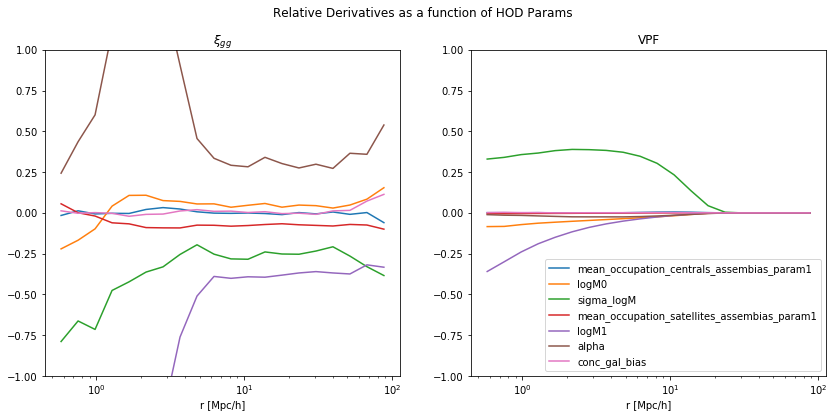

In [13]:
fig = plt.figure(figsize=(14,6))
for i, name in enumerate(pnames):
    plt.subplot(121)
    plt.title(r'$\xi_{gg}$')
    plt.plot(rbc, d_xi[i]/xi_mean)
    plt.xscale('log')
    plt.ylim([-1.0, 1.0])
    plt.xlabel('r [Mpc/h]')

    plt.subplot(122)
    plt.title(r'VPF')

    plt.xscale('log')
    plt.xlabel('r [Mpc/h]')
    plt.plot(rbc, d_vpf[i]/vdf_mean, label = name)
    plt.ylim([-1.0, 1.0])
plt.suptitle('Relative Derivatives as a function of HOD Params')
plt.legend(loc='best')

In [14]:
def cholesky_inv(covmat):
    c = inv(cholesky(vdf_fischer_mat))
    return np.dot(c.T, c)

In [15]:
vdf_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/vdf_covmat.npy')#[5:13][:,5:13]#[:2][:,:2]
xi_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/vdf_fischer/xi_covmat.npy')#[:2][:,:2]

#vdf_covmat+=np.diag(np.ones(vdf_covmat.shape[0]))*1e-3
#xi_covmat-=np.diag(np.ones(xi_covmat.shape[0]))*1e-12

In [16]:
inv_vdf_covmat = inv(vdf_covmat)
inv_xi_covmat = inv(xi_covmat)

In [17]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    denom = np.outer(std, std)
    return cov/denom

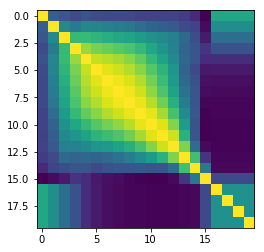

In [18]:
plt.imshow(cov_to_corr(vdf_covmat))

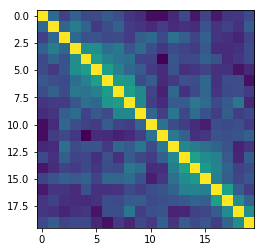

In [19]:
plt.imshow(cov_to_corr(xi_covmat))

In [20]:
d_vdf = d_vdf#[:6]
d_xi = d_xi#[:6]

In [21]:
vdf_fischer_mat = np.dot(d_vdf, np.dot(inv_vdf_covmat, d_vdf.T))
xi_fischer_mat = np.dot(d_xi, np.dot(inv_xi_covmat, d_xi.T))

vdf_info_mat =inv(vdf_fischer_mat)
xi_info_mat = inv(xi_fischer_mat)

In [22]:
# joint constraint
d_all = np.c_[d_vdf, d_xi]
from scipy.linalg import block_diag
full_covmat = block_diag(vdf_covmat, xi_covmat) + np.diag(np.ones(40,))*1e-11
full_fischer_mat = np.dot(d_all, np.dot(inv(full_covmat), d_all.T))
full_info_mat = inv(full_fischer_mat)

In [23]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

In [24]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def ellipse_plot(inv_fisher, mean_x, mean_y, xname, yname, fig, ax, lab, co, scale=False):
    #alpha paramaters for 1 and 2 sigma contours
    #alpha1 = 1.52
    #alpha2 = 2.48
    #extracting relevant params from the input inverse fisher matrix
    sigma_x2 = inv_fisher[0][0]
    sigma_y2 = inv_fisher[1][1]
    sigma_xy = inv_fisher[0][1]
    
    pearson = sigma_xy/np.sqrt(sigma_y2 * sigma_x2)
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    a2 = 2*np.sqrt(1 + pearson)
    b2 = 2*np.sqrt(1 - pearson)
    
    
    #plotting 1 and 2 sigma contours
    #print mean_x, mean_y
    ell = Ellipse(xy = [0, 0], height = np.sqrt(b2), width = np.sqrt(a2), alpha=0.5, fill=True, label=lab, color=co)
    ell2 = Ellipse(xy = [0,0], height = np.sqrt(b2), width = np.sqrt(a2), alpha=0.35, fill=True,  color=co)

    scales = np.sqrt(np.diag(inv_fisher)) #* n_std


    transf1 = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scales[0], scales[1]).translate(mean_x, mean_y) \
        
    transf2 = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scales[0]*2, scales[1]*2).translate(mean_x, mean_y) \
        
    ell.set_transform(transf1 + ax.transData)
    ell2.set_transform(transf2 + ax.transData)

    #adding patches, axis names, etc
    ax.add_patch(ell)
    ax.add_patch(ell2)
    #ax.set_aspect('equal')
    if scale:
        #ax.autoscale()
        n = 3

        sx, sy = np.sqrt(sigma_x2), np.sqrt(sigma_y2)
        ax.set_xlim([mean_x-n*sx, mean_x+n*sx])
        ax.set_ylim([mean_y-n*sy, mean_y+n*sy])
        if xname =='mean_occupation_centrals_assembias_param1':
            xname = 'A_cen'
        elif xname == 'mean_occupation_satellites_assembias_param1':
            xname = 'A_sat'
            
        if yname =='mean_occupation_centrals_assembias_param1':
            yname = 'A_cen'
        elif yname == 'mean_occupation_satellites_assembias_param1':
            yname = 'A_sat'
            
        ax.set_xlabel(xname)
        ax.set_ylabel(yname)

In [25]:
from scipy.stats import norm

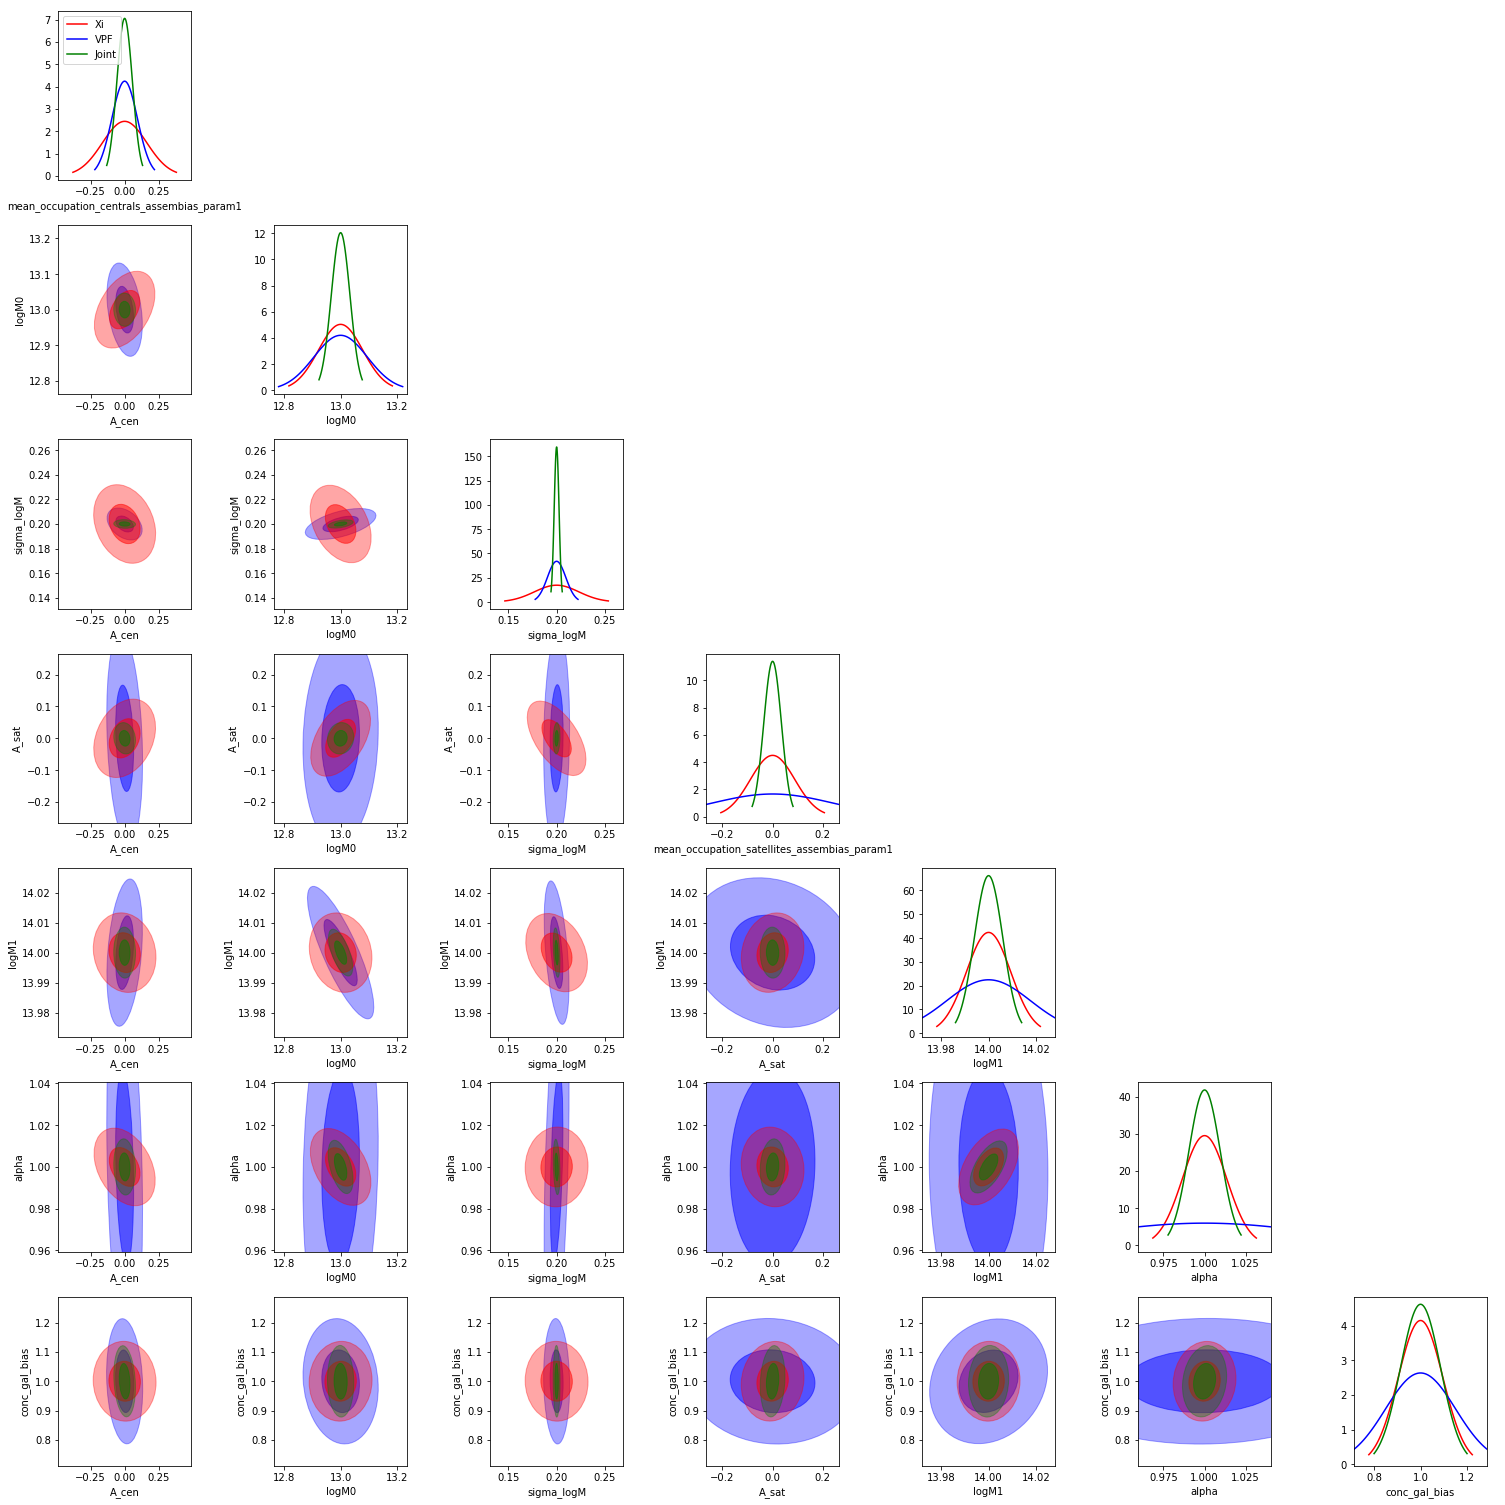

In [26]:
N = d_vdf.shape[0]
size = N*3

fig, axes = plt.subplots(ncols=N, nrows=N, figsize=((size,size)))

for i, name1 in enumerate(pnames[:N]):
    for j, name2 in enumerate(pnames[:N]):
        if i<j:
            axes[i][j].axis('off')
        elif j == i:
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(xi_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'r', label = 'Xi')

            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(vdf_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'b', label ='VPF')
            
            dist = norm(loc = fiducial_hod[name2], scale = np.sqrt(full_info_mat[i,i]) )
            x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
            axes[i][j].plot(x, dist.pdf(x), color = 'g', label ='Joint')
        
            axes[i][j].set_xlabel(name2)
            #axes[i][j].autoscale()
            sx = np.sqrt(xi_info_mat[i,i])
            #print name2, fiducial_hod[name2], sx
            #print name2, fiducial_hod[name2]-5*sx, fiducial_hod[name2]+5*sx
            axes[i][j].set_xlim([fiducial_hod[name2]-3*sx, fiducial_hod[name2]+3*sx])
            if i == 0:
                axes[i][j].legend(loc='upper left')

        else:
            #print vdf_info_mat[np.ix_([i,j],[i,j])]
            #print vdf_info_mat[np.ix_([j,i],[j,i])]
            ellipse_plot(vdf_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'b', lab='VDF', scale=False)
            ellipse_plot(xi_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'r', lab = 'Xi', scale=True)
            ellipse_plot(full_info_mat[np.ix_([j,i],[j,i])], fiducial_hod[name2],\
                         fiducial_hod[name1], name2, name1, fig, axes[i][j], co = 'g', lab = 'Joint', scale=False)
            #print '*'*20
            
fig.tight_layout()

In [27]:
from scipy.stats import multivariate_normal

In [28]:
pnames

['mean_occupation_centrals_assembias_param1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'logM1',
 'alpha',
 'conc_gal_bias']

1 0
logM0 mean_occupation_centrals_assembias_param1


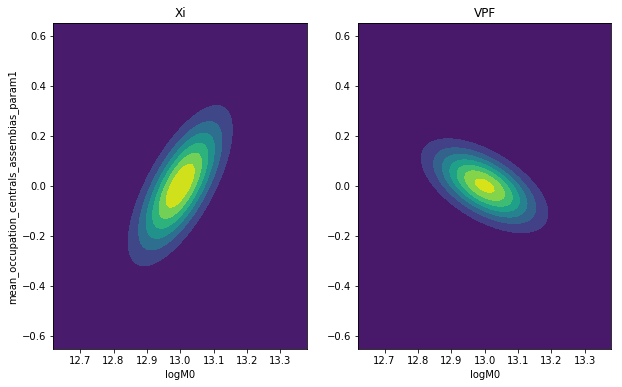

2 0
sigma_logM mean_occupation_centrals_assembias_param1


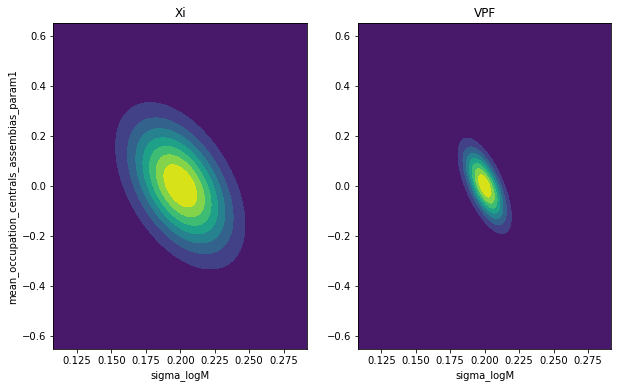

2 1
sigma_logM logM0


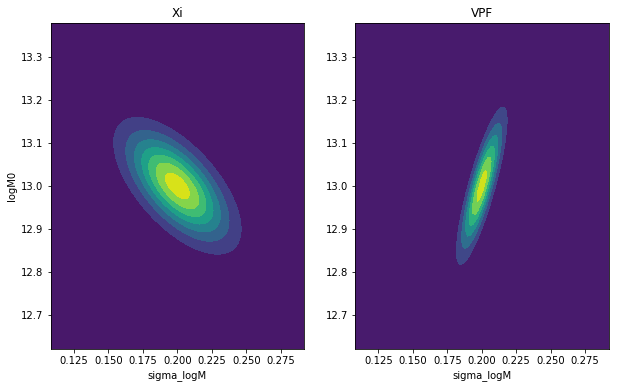

3 0
mean_occupation_satellites_assembias_param1 mean_occupation_centrals_assembias_param1


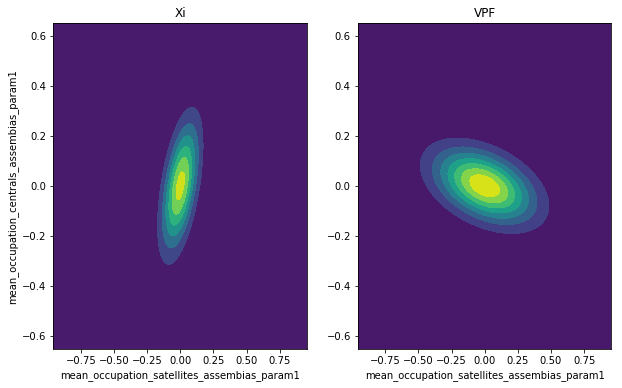

3 1
mean_occupation_satellites_assembias_param1 logM0


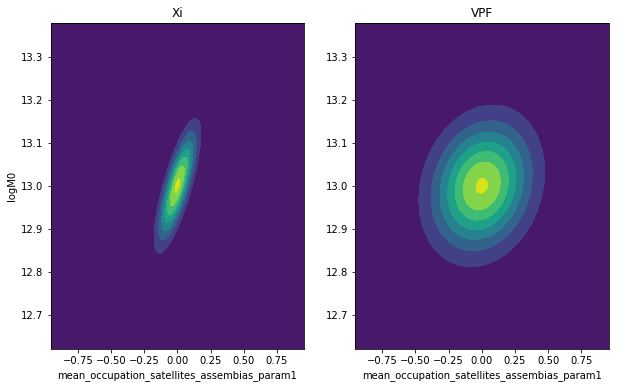

3 2
mean_occupation_satellites_assembias_param1 sigma_logM


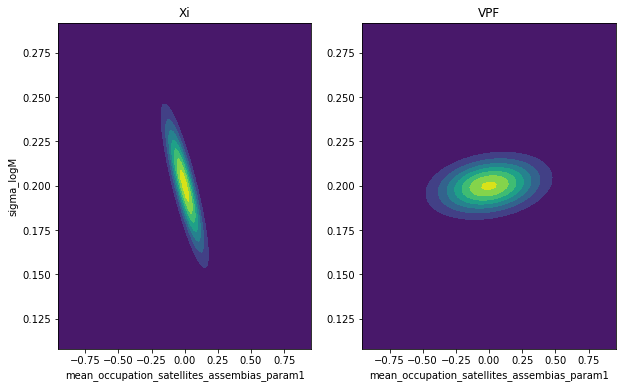

4 0
logM1 mean_occupation_centrals_assembias_param1


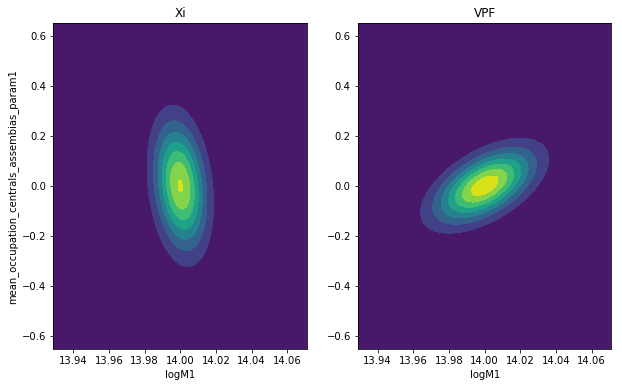

4 1
logM1 logM0


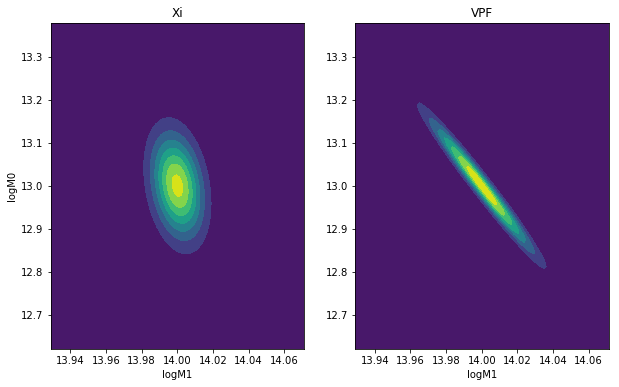

4 2
logM1 sigma_logM


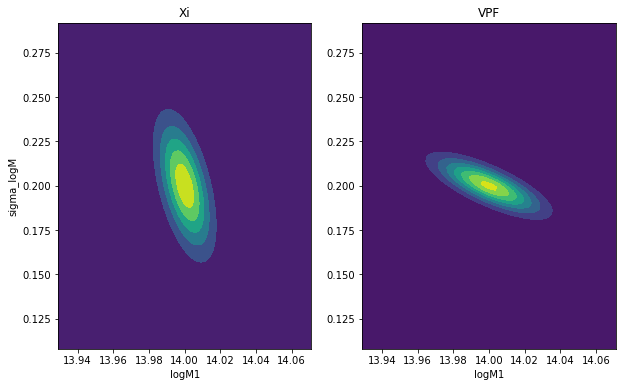

4 3
logM1 mean_occupation_satellites_assembias_param1


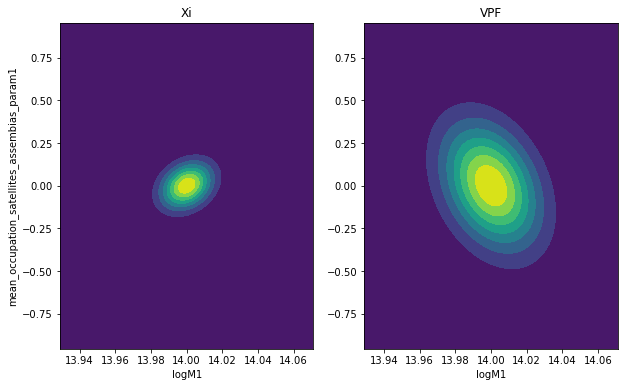

5 0
alpha mean_occupation_centrals_assembias_param1


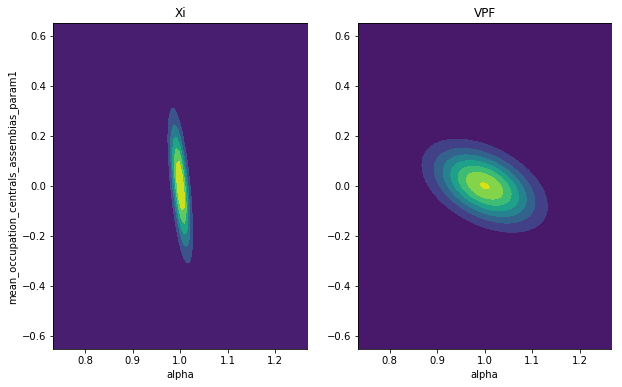

5 1
alpha logM0


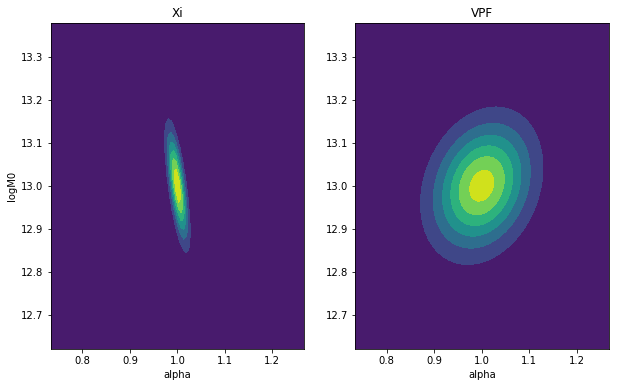

5 2
alpha sigma_logM


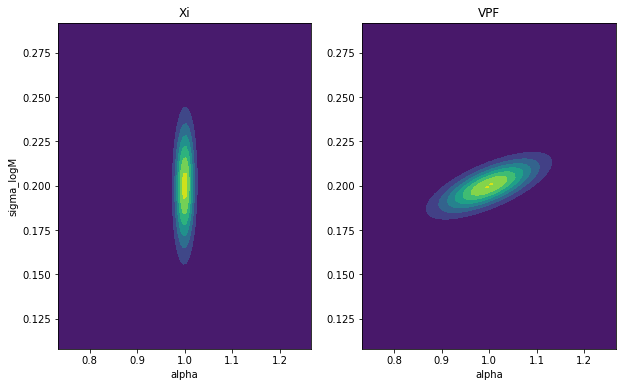

5 3
alpha mean_occupation_satellites_assembias_param1


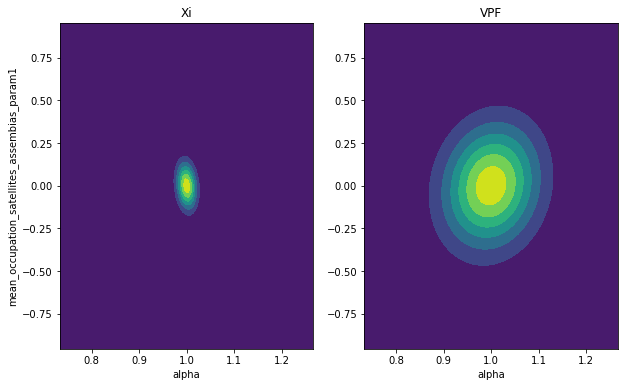

5 4
alpha logM1


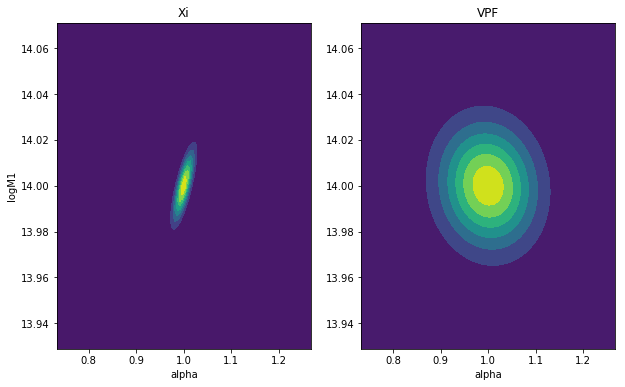

6 0
conc_gal_bias mean_occupation_centrals_assembias_param1


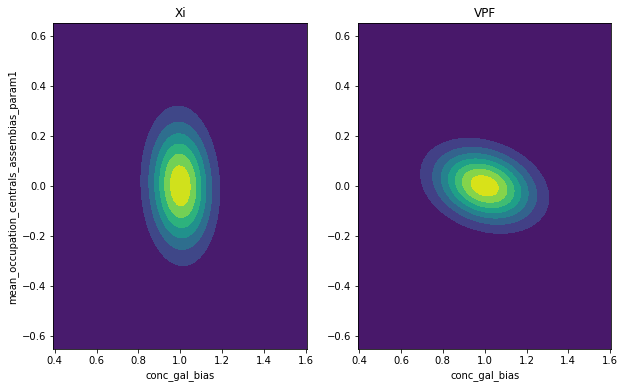

6 1
conc_gal_bias logM0


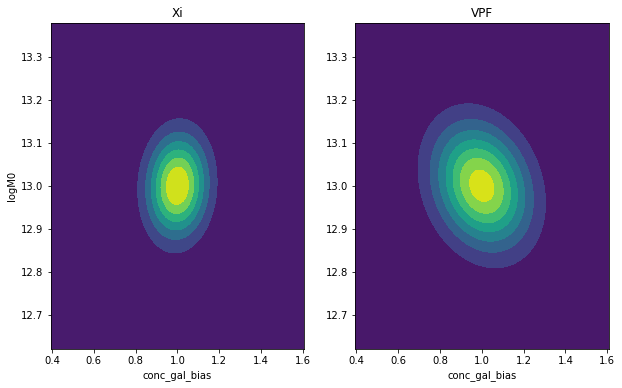

6 2
conc_gal_bias sigma_logM


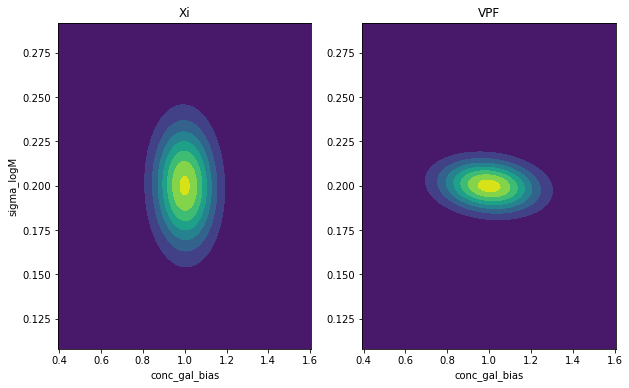

6 3
conc_gal_bias mean_occupation_satellites_assembias_param1


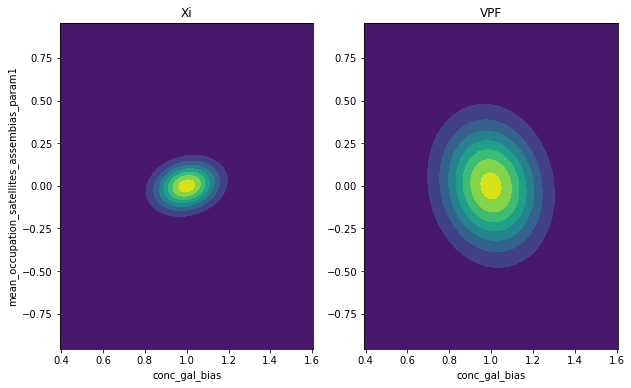

6 4
conc_gal_bias logM1


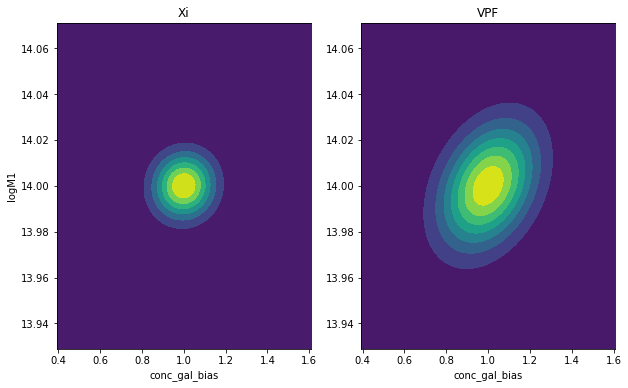

6 5
conc_gal_bias alpha


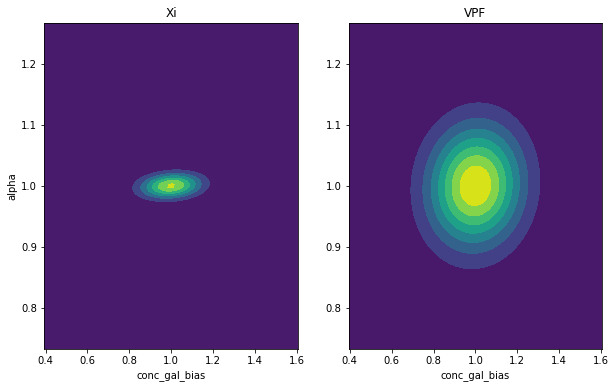

In [29]:
N = d_vdf.shape[0]
size = N*3

#fig, axes = plt.subplots(ncols=N, nrows=N, figsize=((size,size)))



for i, name1 in enumerate(pnames[:N]):

    for j, name2 in enumerate(pnames[:i+1]):
        if i==j:
            continue
        fig, axes = plt.subplots(1,2, figsize=(10,6))
        print i,j
        print name1, name2
        for l, ax in enumerate(axes):
            if l == 0:
                Sigma = xi_info_mat[np.ix_([i,j],[i,j])]
            else:
                Sigma = vdf_info_mat[np.ix_([i,j],[i,j])]
                
            mu = np.array([fiducial_hod[name1], fiducial_hod[name2]])
            F = multivariate_normal(mu, Sigma)
            s = np.maximum(np.sqrt(np.diag(xi_info_mat[np.ix_([i,j],[i,j])])),\
                           np.sqrt(np.diag(vdf_info_mat[np.ix_([i,j],[i,j])])))
            pos = np.meshgrid(*[np.linspace(mu[k]-4*s[k],\
                                            mu[k]+4*s[k], 100)\
                                         for k in xrange(len(mu))])
            X,Y = pos
            Z = F.pdf(np.dstack(pos).reshape((-1, 2))) 
            Z = Z.reshape(X.shape)
            #plt.title(name1 + '+'+name2)
            
            ax.set_xlabel(name1)
            if l == 0:
                ax.set_ylabel(name2)
                
            if l==0:
                ax.set_title('Xi')
            else:
                ax.set_title('VPF')
            cp = ax.contourf(X, Y, Z)
            #fig.colorbar(cp) # Add a colorbar to a plot
        plt.show()
        
        
#plt.show()